In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np

#### Train LSTM model

Epoch 1/200, Train Loss: 7.845937961107724, Val Loss: 5.152286706826626, R²: -1.3116516238494849, Params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 200, 'dropout_rate': 0.7, 'weight_decay': 0.0001, 'patience': 10}
Checkpoint saved at epoch 1 with R²: -1.3116516238494849
Epoch 2/200, Train Loss: 2.6031622282870406, Val Loss: 0.6900319999609238, R²: 0.6893007696105681, Params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 200, 'dropout_rate': 0.7, 'weight_decay': 0.0001, 'patience': 10}
Checkpoint saved at epoch 2 with R²: 0.6893007696105681
Epoch 3/200, Train Loss: 0.9915052869103171, Val Loss: 0.5362470207306055, R²: 0.7576491375491071, Params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 200, 'dropout_rate': 0.7, 'weight_decay': 0.0001, 'patience': 10}
Checkpoint saved at epoch 3 with R²: 0.7576491375491071
Epoch 4/200, Train Loss: 0.8

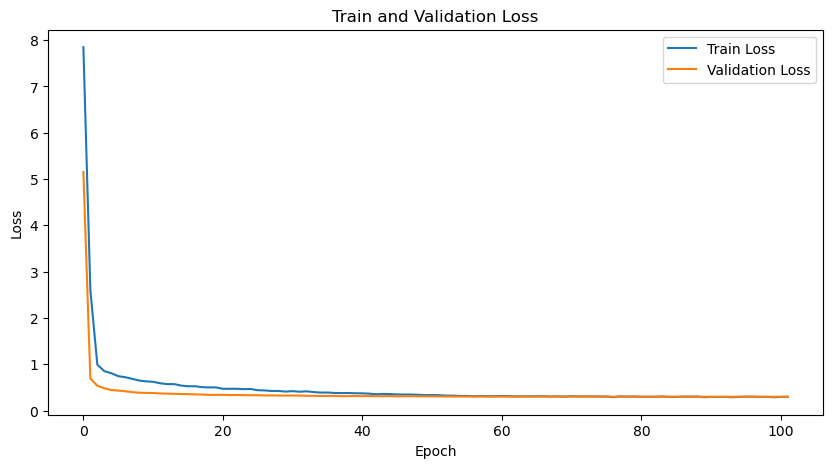

Final MSE: 0.30033931136131287
Final R²: 0.8651292720875547


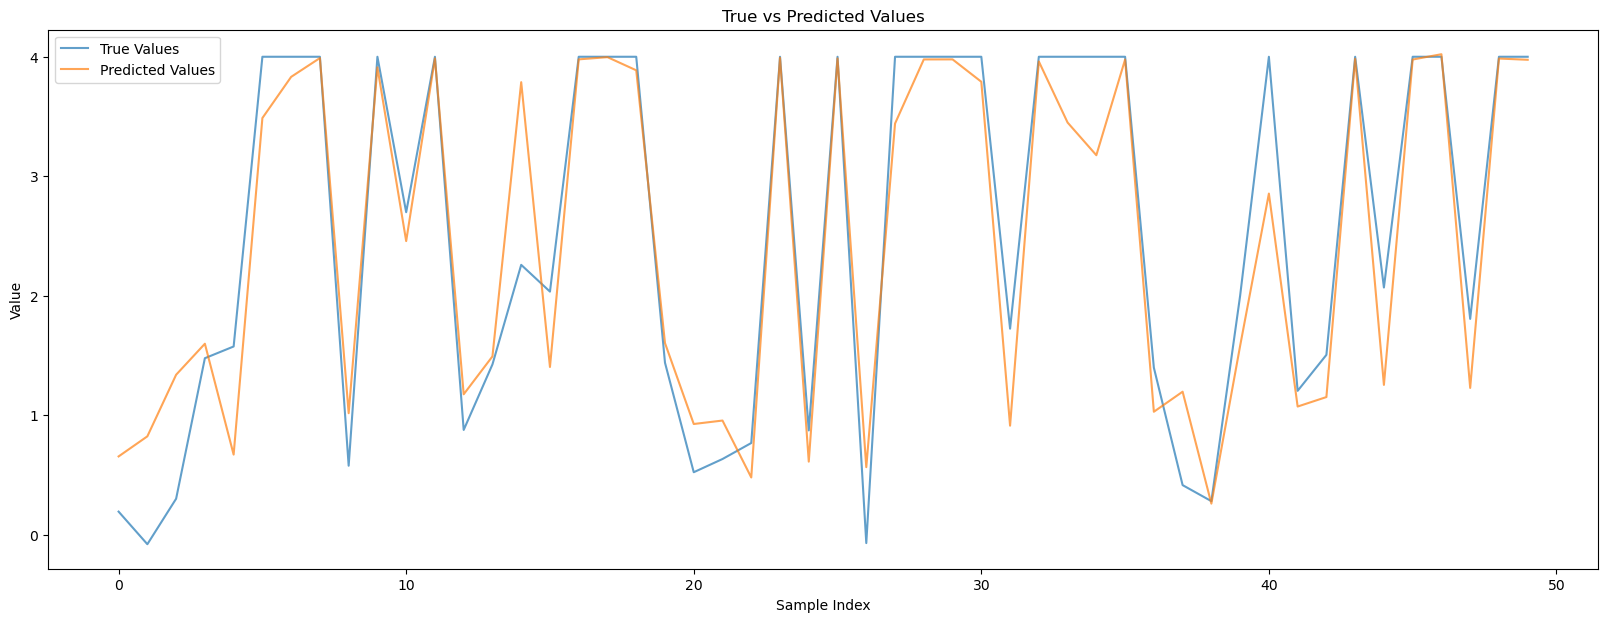

In [3]:

# load data
data = pd.read_csv('/media/zzh/data/AMP/LSTMregrssion/data/train5_65_stpa_mean_representations.csv')

# x as feature y as logMIC
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Data standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)


# # Save the standardizer
# with open('/media/zzh/data/AMP/LSTMregrssion/LSTM_model/ecoliscaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# change to tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)  

# Dataset split (retain 20% as the validation set)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loader
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
val_dataset = TensorDataset(X_val.unsqueeze(1), y_val)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Training and validation functions
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, patience, params):
    train_losses = []
    val_losses = []
    best_r2 = -float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # trainning step
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)  # Modify to outputs.squeeze() to match the dimensions of y_batch
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # valid step
        model.eval()
        val_loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)  # Modify to outputs.squeeze() to match the dimensions of y_batch
                val_loss += loss.item()
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(outputs.squeeze().cpu().numpy())
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        # calculate R²
        r2 = r2_score(y_true, y_pred)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, R²: {r2}, Params: {params}')
        
        # save best model
        if r2 > best_r2:
            best_r2 = r2
            patience_counter = 0
            torch.save(model.state_dict(), 'stpa_best_model_checkpoint.pth')
            print(f'Checkpoint saved at epoch {epoch+1} with R²: {r2}')
        else:
            patience_counter += 1
        
        # refesh learning rate
        scheduler.step(val_loss)

        # Early stopping strategy
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses

def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.squeeze().cpu().numpy())
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mse, r2, y_true, y_pred

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Determined hyperparameters
    best_params = {
        'hidden_size': 128,
        'num_layers': 2,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'num_epochs': 200,
        'dropout_rate': 0.7,
        'weight_decay': 0.0001,  # Add the weight_decay parameter to implement L2 regularization
        'patience': 10  # Patience parameter for the early stopping strategy
    }

    # Train the model using the best parameters
    model = LSTMModel(input_size=X_train.size(1), hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers'], output_size=1, dropout_rate=best_params['dropout_rate']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    train_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train), batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val), batch_size=best_params['batch_size'], shuffle=False)
    
    train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, best_params['num_epochs'], best_params['patience'], best_params)
    
    # Plot the training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')
    plt.show()
    
    # Load the model that performed best on the validation set
    model.load_state_dict(torch.load('stpa_best_model_checkpoint.pth'))

    # Validate the final model and calculate MSE and R²
    mse, r2, y_true, y_pred = evaluate_model(model, val_loader)

    print(f"Final MSE: {mse}")
    print(f"Final R²: {r2}")

    # Plot the curve of predicted values and true values
    plt.figure(figsize=(20, 7))

    # Display only the first 50 samples
    n_samples_to_plot = 50
    plt.plot(y_true[:n_samples_to_plot], label='True Values', alpha=0.7)
    plt.plot(y_pred[:n_samples_to_plot], label='Predicted Values', alpha=0.7)

    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('True vs Predicted Values')
    plt.show()

#### plt for best model

Final MSE: 5.212507724761963
Final RMSE: 2.2830917835235596
Final R²: -1.2566880630995403


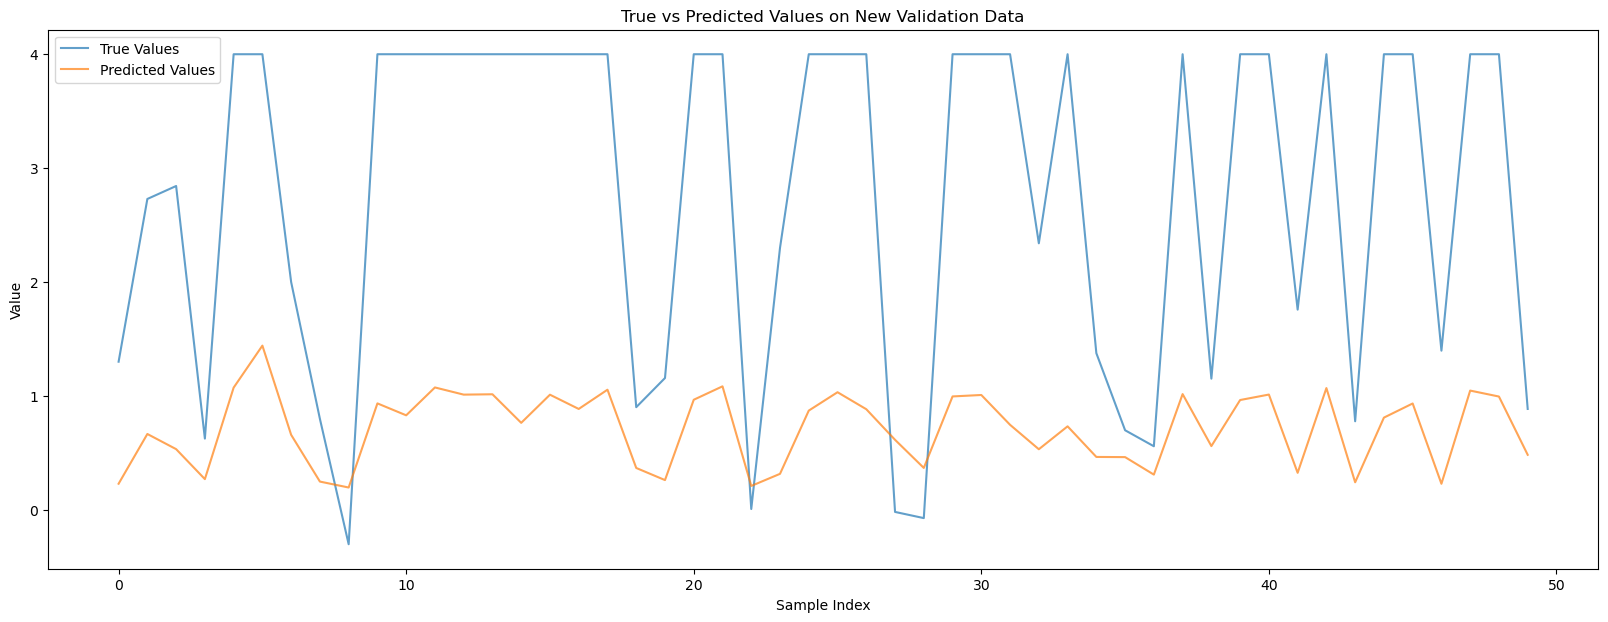

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Defined LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# load new data
new_val_data = pd.read_csv('/media/zzh/data/AMP/LSTMregrssion/data/last5_65_ecoli_mean_representations.csv')
X_new_val = new_val_data.iloc[:, 1:-1].values  # freature column
y_new_val = new_val_data.iloc[:, -1].values    # logMIC column

# Load the standardizer and perform standardization
with open('/media/zzh/data/AMP/LSTMregrssion/LSTM_model/stpascaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
X_new_val = scaler.transform(X_new_val)

# change to tensor
X_new_val = torch.tensor(X_new_val, dtype=torch.float32)
y_new_val = torch.tensor(y_new_val, dtype=torch.float32)

# Create data loader
new_val_dataset = TensorDataset(X_new_val.unsqueeze(1), y_new_val)
new_val_loader = DataLoader(new_val_dataset, batch_size=64, shuffle=False)

# load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=X_new_val.size(1), hidden_size=128, num_layers=2, output_size=1, dropout_rate=0.7).to(device)
model.load_state_dict(torch.load('/media/zzh/data/AMP/LSTMregrssion/LSTM_model/2ecoli_best_model_checkpoint.pth'))
model.eval()

# Make prediction
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in new_val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.squeeze().cpu().numpy())

# Calculate performance metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Final MSE: {mse}")
print(f"Final RMSE: {rmse}")
print(f"Final R²: {r2}")

# Plot the curve of true values and predicted values
plt.figure(figsize=(20, 7))

# Display only the first 50 samples
n_samples_to_plot = 50
plt.plot(y_true[:n_samples_to_plot], label='True Values', alpha=0.7)
plt.plot(y_pred[:n_samples_to_plot], label='Predicted Values', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.title('True vs Predicted Values on New Validation Data')
plt.show()